In [ ]:
#Mount your drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Add imports here

import os
import pathlib
import cv2
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop , Adam , Adamax , Adadelta
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import *
import pandas as pd
from tensorflow.keras.utils import plot_model

In [ ]:
! cp '/content/drive/MyDrive/project/Chest_XRay_DS.zip' /content/

In [ ]:
!unzip "/content/Chest_XRay_DS.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Chest_XRay_DS/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0438-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0439-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0440-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0441-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0442-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0444-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0445-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0446-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0447-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0448-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0449-0001.jpeg  
  inflating: Chest_XRay_DS/train/NORMAL/IM-0450-0001.jpeg  
  inflating: Chest_XRay_DS/train/N

In [ ]:
# Define the classes
CLASSES = ['NORMAL', 'PNEUMONIA'] 
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def load_image_and_label(image_path, target_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32)
    image = tf.image.resize(image, target_size)

    # label is the directory name
    label = tf.strings.split(image_path, os.path.sep)[-2]
    #Chest_XRay_DS/train/PNEUMONIA/person998_bacteria_2928.jpeg
    label = (label == CLASSES)  # One-hot encode.
    label = tf.dtypes.cast(label, tf.float32)


    return image, label

In [ ]:
def prepare_dataset(dataset_path,
                    buffer_size,
                    batch_size,
                    shuffle=True):
    dataset = (tf.data.Dataset
               .from_tensor_slices(dataset_path)
               .map(load_image_and_label,
                    num_parallel_calls=AUTOTUNE))

    if shuffle:
        dataset.shuffle(buffer_size=buffer_size)

    dataset = (dataset
               .batch(batch_size=batch_size)
               .prefetch(buffer_size=buffer_size))

    return dataset

In [ ]:
# get a list of all images
file_pattern = 'Chest_XRay_DS/*/*/*.jpeg'
file_pattern = str(file_pattern)
dataset_paths = glob.glob(file_pattern)

# split the data to train/validation/test splits
train_paths, test_paths = train_test_split(dataset_paths,
                                           test_size=0.2,
                                           random_state=999)
train_paths, val_paths = train_test_split(train_paths,
                                          test_size=0.2,
                                          random_state=999)

In [ ]:
# create the diffirent datasets
BATCH_SIZE = 64
BUFFER_SIZE = 1024
train_dataset = prepare_dataset(train_paths,
                                buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE)
validation_dataset = prepare_dataset(val_paths,
                                     buffer_size=BUFFER_SIZE,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)
test_dataset = prepare_dataset(test_paths,
                               buffer_size=BUFFER_SIZE,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import layers

base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

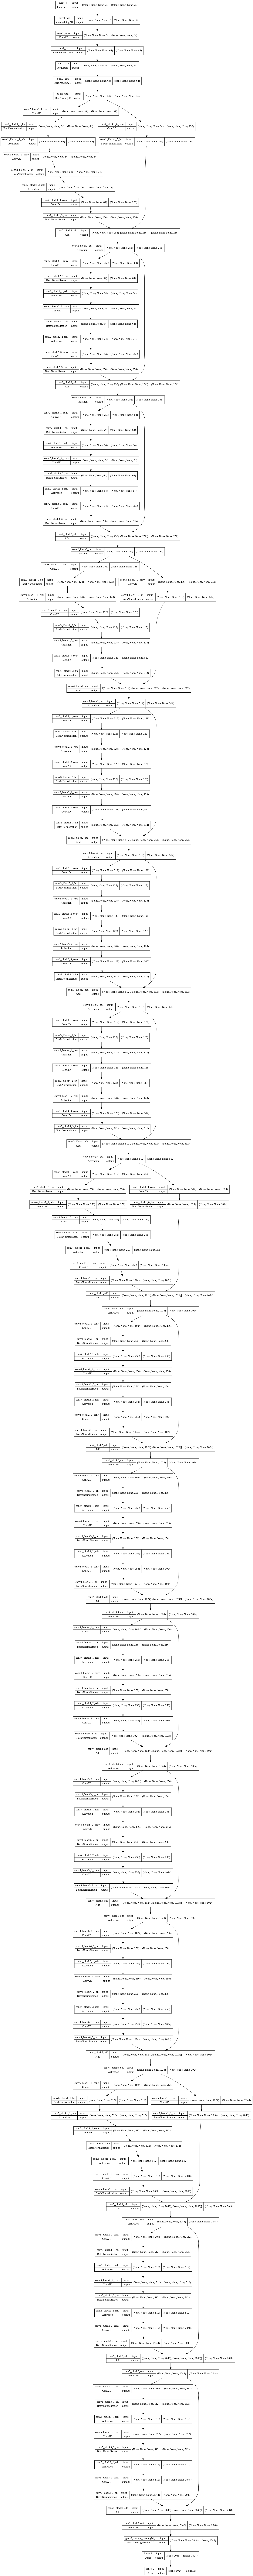

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
model.compile(optimizer = 'adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
EPOCHS = 20
model_history = model.fit(train_dataset,
                validation_data=validation_dataset,
                epochs=EPOCHS)

Epoch 1/20
59/59 [==============================] - 52s 827ms/step - loss: 0.6643 - accuracy: 0.6931 - val_loss: 0.4834 - val_accuracy: 0.7300
Epoch 2/20
59/59 [==============================] - 47s 804ms/step - loss: 0.4546 - accuracy: 0.7809 - val_loss: 0.4099 - val_accuracy: 0.7972
Epoch 3/20
59/59 [==============================] - 46s 782ms/step - loss: 0.4132 - accuracy: 0.8006 - val_loss: 0.3746 - val_accuracy: 0.8228
Epoch 4/20
59/59 [==============================] - 46s 780ms/step - loss: 0.3958 - accuracy: 0.8159 - val_loss: 0.3563 - val_accuracy: 0.8431
Epoch 5/20
59/59 [==============================] - 46s 784ms/step - loss: 0.3814 - accuracy: 0.8239 - val_loss: 0.3415 - val_accuracy: 0.8527
Epoch 6/20
59/59 [==============================] - 48s 813ms/step - loss: 0.3674 - accuracy: 0.8345 - val_loss: 0.3280 - val_accuracy: 0.8634
Epoch 7/20
59/59 [==============================] - 46s 783ms/step - loss: 0.3549 - accuracy: 0.8425 - val_loss: 0.3163 - val_accuracy: 0.8666

In [ ]:
# test the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Loss: {test_loss}, accuracy: {test_accuracy}')

19/19 [==============================] - 12s 599ms/step - loss: 0.1994 - accuracy: 0.9181
Loss: 0.1993510127067566, accuracy: 0.9180887341499329


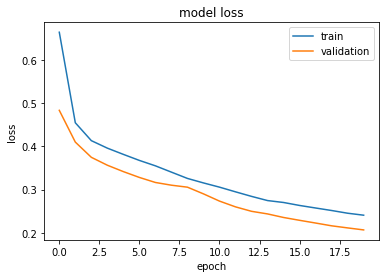

In [ ]:
# plot the loss history
import matplotlib.pyplot as plt


plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

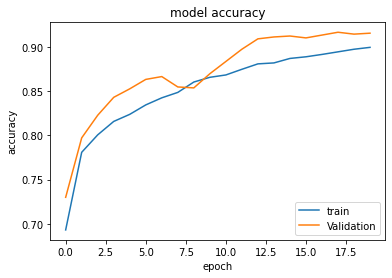

In [ ]:
# plot the accuracy history
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# save the model
model.save('model.hdf5')

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   for i in label_batch:
     y_true.append(np.argmax(i))
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

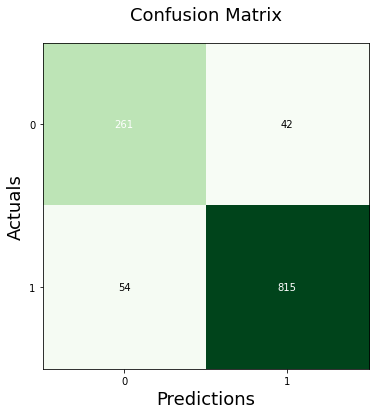

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       303
           1       0.95      0.94      0.94       869

    accuracy                           0.92      1172
   macro avg       0.89      0.90      0.89      1172
weighted avg       0.92      0.92      0.92      1172



In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = sklearn.metrics.confusion_matrix(correct_labels, predicted_labels)
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print(classification_report(correct_labels, predicted_labels))

## Testing a single image on trained model

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import *

model = load_model('/content/drive/model.hdf5') #Add path to the saved model

path = "/content/photo.jpg"  #To test a single image, add its path here 

image = load_img(path, target_size=(224, 224)) #Read the img
image = img_to_array(image)
image = image.astype('float') / 255.0 #Normalization 

image = image.reshape(1, 224, 224, 3)

In [ ]:
img_res = model.predict(image)
img_res = np.argmax(img_res)
print (img_res)